<a href="https://colab.research.google.com/github/armandoalbornoz/replicating_paper/blob/main/Deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pytorch Model Deployment

## Get Data

We are going to use the 20% pizza, steak, sushi dataset.

In [1]:
# Setup
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1534/1534), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 4393 (delta 1457), reused 1399 (delta 1399), pack-reused 2859 (from 2)
Receiving objects: 100% (4393/4393), 650.71 MiB | 16.57 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Getting Data

In [3]:

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path


[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [4]:
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## Experiments

We are going to build two models:

1. EffNetB2 feature extractor
2. ViT feature extractor

Our goal is to pick a model that is both fast and accurate.

## Creating EffNetB2 feature extractor



In [5]:
# Get pretrained model and transforms
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
transforms = effnetb2_weights.transforms()
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights).to(device)

# Freeze base layers
for param in effnetb2.features.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 174MB/s]


In [6]:
from torchinfo import summary

summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [7]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [8]:
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408,
              out_features=3,
              bias=True)).to(device)

In [9]:
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [10]:
def create_effnetb2_model(num_classes=3):

  effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = effnetb2_weights.transforms()
  effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights).to(device)

  # Freeze base layers
  for param in effnetb2.features.parameters():
      param.requires_grad = False

  effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408,
              out_features=num_classes,
              bias=True)).to(device)

  return effnetb2, transforms

In [11]:
effnetb2, effnetb2_transforms = create_effnetb2_model(3)

In [12]:
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### Creating Dataloaders for EffNetB2



In [13]:
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=effnetb2_transforms,
    batch_size=32
)

## Training EffNetB2 feature extractor

In [14]:
optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [15]:
from going_modular.going_modular import engine

effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9526 | train_acc: 0.6438 | test_loss: 0.7297 | test_acc: 0.8858
Epoch: 2 | train_loss: 0.7181 | train_acc: 0.7771 | test_loss: 0.5965 | test_acc: 0.9318
Epoch: 3 | train_loss: 0.5845 | train_acc: 0.8625 | test_loss: 0.5224 | test_acc: 0.9443
Epoch: 4 | train_loss: 0.4757 | train_acc: 0.8708 | test_loss: 0.4540 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4129 | train_acc: 0.9083 | test_loss: 0.4139 | test_acc: 0.9318
Epoch: 6 | train_loss: 0.3832 | train_acc: 0.9104 | test_loss: 0.3671 | test_acc: 0.9472
Epoch: 7 | train_loss: 0.4365 | train_acc: 0.8875 | test_loss: 0.3462 | test_acc: 0.9409
Epoch: 8 | train_loss: 0.3681 | train_acc: 0.8812 | test_loss: 0.3371 | test_acc: 0.9597
Epoch: 9 | train_loss: 0.3179 | train_acc: 0.9375 | test_loss: 0.3239 | test_acc: 0.9534
Epoch: 10 | train_loss: 0.2958 | train_acc: 0.9167 | test_loss: 0.2887 | test_acc: 0.9563


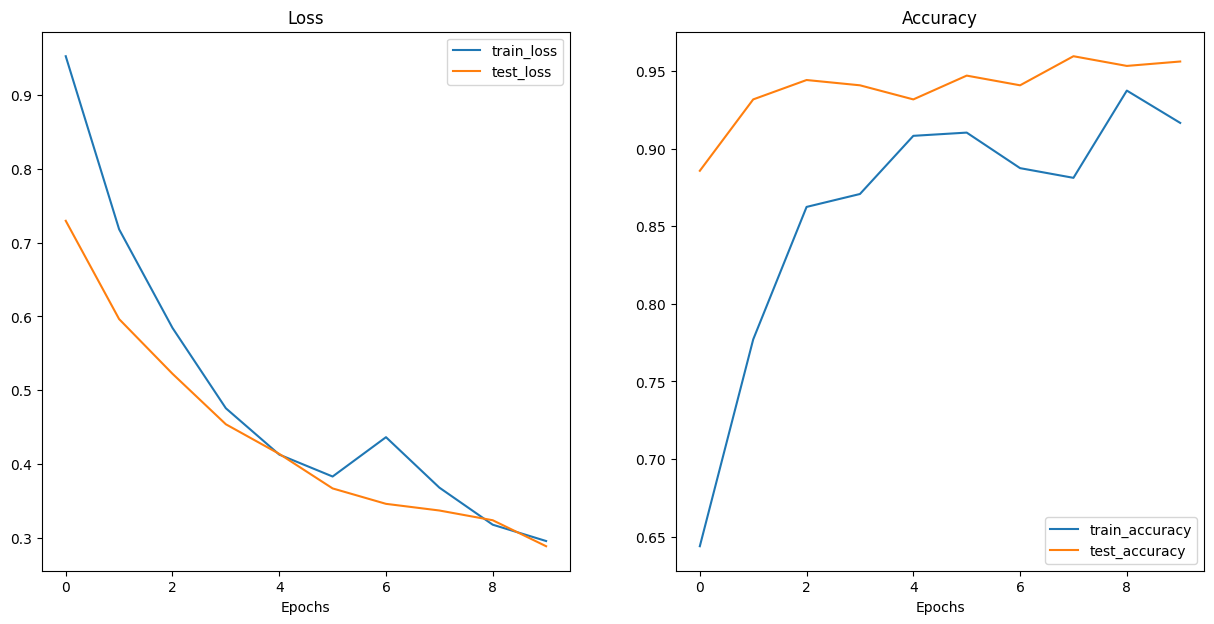

In [16]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

## Saving EffNetB2 feature extractor

In [17]:
from going_modular.going_modular import utils

utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="pretrained_effnetb2_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi.pth


### Inspecting size of model

In [18]:
from pathlib import Path

model_path = Path("models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi.pth")
model_size_mb = model_path.stat().st_size / (1024 * 1024)
print(f"Model size: {model_size_mb:.2f} MB")

Model size: 29.85 MB


## Collecting EffNetB2 properties

In [19]:
# Count the number of parameters
total_params = sum(torch.numel(param) for param in effnetb2.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 7705221


In [20]:
# Create a dictionary with the statistics

effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters" : total_params ,
                  "model_size (MB)" :model_size_mb
                  }

In [21]:
effnetb2_stats

{'test_loss': 0.2887403279542923,
 'test_acc': 0.95625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8526554107666}

## Creating the ViT model

In [22]:
def create_vit_model(num_classes=3):

  vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = vit_weights.transforms()
  vit = torchvision.models.vit_b_16(weights=vit_weights).to(device)

  # Freeze base layers
  for param in vit.parameters():
      param.requires_grad = False

  vit.heads


  vit.heads = nn.Sequential(
    nn.Linear(in_features=768,
              out_features=num_classes,
              bias=True)).to(device)

  return vit, transforms

In [23]:
vit, vit_transforms = create_vit_model(3)
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 139MB/s]


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

## Creating Dataloaders

In [24]:
# Creating Dataloaders for vit

from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transforms,
    batch_size=32
)

## Vit Training

In [25]:
optimizer = torch.optim.Adam(params=vit.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [26]:
from going_modular.going_modular import engine

vit_results = engine.train(model=vit,
                                train_dataloader=train_dataloader_vit,
                                test_dataloader=test_dataloader_vit,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5888 | train_acc: 0.8125 | test_loss: 0.2277 | test_acc: 0.9534
Epoch: 2 | train_loss: 0.2098 | train_acc: 0.9458 | test_loss: 0.1294 | test_acc: 0.9938
Epoch: 3 | train_loss: 0.1488 | train_acc: 0.9563 | test_loss: 0.0980 | test_acc: 1.0000
Epoch: 4 | train_loss: 0.1346 | train_acc: 0.9604 | test_loss: 0.0837 | test_acc: 0.9938
Epoch: 5 | train_loss: 0.1128 | train_acc: 0.9688 | test_loss: 0.0770 | test_acc: 0.9875
Epoch: 6 | train_loss: 0.0893 | train_acc: 0.9771 | test_loss: 0.0700 | test_acc: 0.9938
Epoch: 7 | train_loss: 0.0754 | train_acc: 0.9792 | test_loss: 0.0630 | test_acc: 1.0000
Epoch: 8 | train_loss: 0.0668 | train_acc: 0.9854 | test_loss: 0.0618 | test_acc: 0.9938
Epoch: 9 | train_loss: 0.0589 | train_acc: 0.9875 | test_loss: 0.0598 | test_acc: 0.9938
Epoch: 10 | train_loss: 0.0535 | train_acc: 0.9917 | test_loss: 0.0570 | test_acc: 0.9938


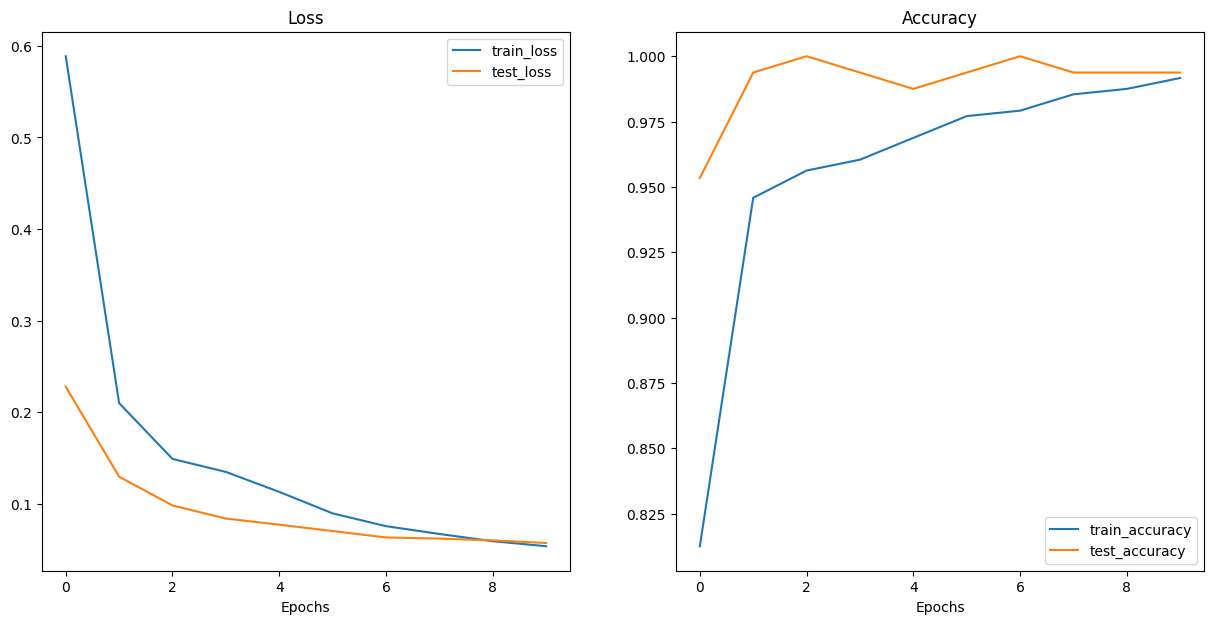

In [27]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

## Saving Vit Model

In [28]:
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="pretrained_vit_b_16_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/pretrained_vit_b_16_feature_extractor_pizza_steak_sushi.pth


## Inspecting size of model


In [29]:
from pathlib import Path

model_path = Path("models/pretrained_vit_b_16_feature_extractor_pizza_steak_sushi.pth")
model_size_mb = model_path.stat().st_size / (1024 * 1024)
print(f"Model size: {model_size_mb:.2f} MB")

Model size: 327.37 MB


## Collecting Vit feuature extractor properties

In [30]:
# Count the number of parameters
total_params = sum(torch.numel(param) for param in vit.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 85800963


In [31]:
# Create a dictionary with the statistics

vit_stats = {"test_loss": vit_results["test_loss"][-1],
                  "test_acc": vit_results["test_acc"][-1],
                  "number_of_parameters" : total_params ,
                  "model_size (MB)" :model_size_mb
                  }

In [32]:
vit_stats

{'test_loss': 0.05696649244055152,
 'test_acc': 0.99375,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.3695697784424}

## Making predictions with our models and timing them

In [33]:
from pathlib import Path

# get all test data paths

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:10]

[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/39461.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1902895.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/219196.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3173402.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/399377.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1166047.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2475366.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/595836.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/108310.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2315011.jpg')]

In [34]:
## Let's create a function that makes predictionss across the dataset

import pathlib
import torch
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
  pred_list = []

  # Loop through the paths

  for path in tqdm(paths):
    # Create an dictionary for each sample
    pred_dict = {}

    # Get the sample path and label frrom the filepath
    pred_dict["image_path"] = path
    class_name = path.parent.name
    pred_dict["class_name"] = class_name

    # Start the prediction timer
    start_time= timer()

    img = Image.open(path)

    transformed_img = transform(img).unsqueeze(0).to(device) # We also add a batch dimension

    model = model.to(device)
    model.eval()

    with torch.inference_mode():
      pred_logits = model(transformed_img)
      pred_probs = torch.softmax(pred_logits, dim=1)
      pred_label = torch.argmax(pred_probs, dim=1)
      pred_class = class_names[pred_label.cpu()] # harcode prediction class to be on CPU (Python variables live on CPU)


      pred_dict["pred_prob"] = round(pred_probs.max().item(), 4)
      pred_dict["pred_class"] =  pred_class

      end_timer = timer()
      pred_dict["prediction_time"] = round(end_timer - start_time, 4)

    pred_dict["correct"] = class_name == pred_class

    pred_list.append(pred_dict)

  return pred_list

## EffnetB2 making and timing predictions

1. Our predictions will happen on the CPU since not all devices have a GPU.




In [35]:
effnetb2_test_predictions = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [36]:
effnetb2_test_predictions[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/39461.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.6301,
  'pred_class': 'steak',
  'prediction_time': 0.3348,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1902895.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.4813,
  'pred_class': 'sushi',
  'prediction_time': 0.1116,
  'correct': False}]

In [37]:
# Turn the list of dictionaries into a dataframe

import pandas as pd

effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_predictions)
effnetb2_test_pred_df

,image_path,class_name,pred_prob,pred_class,prediction_time,correct
0,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.6301,steak,0.3348,True
1,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.4813,sushi,0.1116,False
2,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9222,steak,0.1112,True
3,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9023,steak,0.1063,True
4,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.6755,steak,0.1083,True
...,...,...,...,...,...,...
145,data/pizza_steak_sushi_20_percent/test/sushi/4...,sushi,0.8913,sushi,0.0874,True
146,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.5422,sushi,0.0901,True
147,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.8003,sushi,0.0915,True
148,data/pizza_steak_sushi_20_percent/test/sushi/5...,sushi,0.5048,sushi,0.1086,True


In [38]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

,count
correct,
True,143
False,7


In [39]:
# Let's find the average time per prediction

effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.prediction_time.mean(), 4)
effnetb2_average_time_per_pred

np.float64(0.0986)

## ViT making and timing predictions


In [40]:
vit_test_predictions = pred_and_store(paths=test_data_paths,
                                          model=vit,
                                          transform=vit_transforms,
                                          class_names=class_names,
                                          device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [41]:
vit_test_predictions[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/39461.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.8501,
  'pred_class': 'steak',
  'prediction_time': 0.7578,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1902895.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.645,
  'pred_class': 'steak',
  'prediction_time': 0.5491,
  'correct': True}]

In [42]:
# Turn the list of dictionaries into a dataframe

import pandas as pd

vit_test_pred_df = pd.DataFrame(vit_test_predictions)
vit_test_pred_df

,image_path,class_name,pred_prob,pred_class,prediction_time,correct
0,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.8501,steak,0.7578,True
1,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.6450,steak,0.5491,True
2,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9878,steak,0.5040,True
3,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9962,steak,0.3615,True
4,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9472,steak,0.3697,True
...,...,...,...,...,...,...
145,data/pizza_steak_sushi_20_percent/test/sushi/4...,sushi,0.9944,sushi,0.3747,True
146,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.9919,sushi,0.3550,True
147,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.9940,sushi,0.3554,True
148,data/pizza_steak_sushi_20_percent/test/sushi/5...,sushi,0.7908,sushi,0.3778,True


In [43]:
# Check number of correct predictions
vit_test_pred_df.correct.value_counts()

,count
correct,
True,149
False,1


In [44]:
# Let's find the average time per prediction

vit_average_time_per_pred = round(vit_test_pred_df.prediction_time.mean(), 4)
vit_average_time_per_pred

np.float64(0.4189)

In [45]:
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred

## Comparing model results, prediction time and size of the models

In [46]:
df = pd.DataFrame([effnetb2_stats, vit_stats])
df["model"] = ["EffNetB2", "ViT"]
df["test_acc"] = round(df["test_acc"] * 100, 2 )
df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.288740,95.62,7705221,29.852655,0.0986,EffNetB2
1,0.056966,99.38,85800963,327.369570,0.4189,ViT


# Ratio Comparisons

In [47]:
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]),
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.197293,1.039322,11.135432,10.966179,4.248479


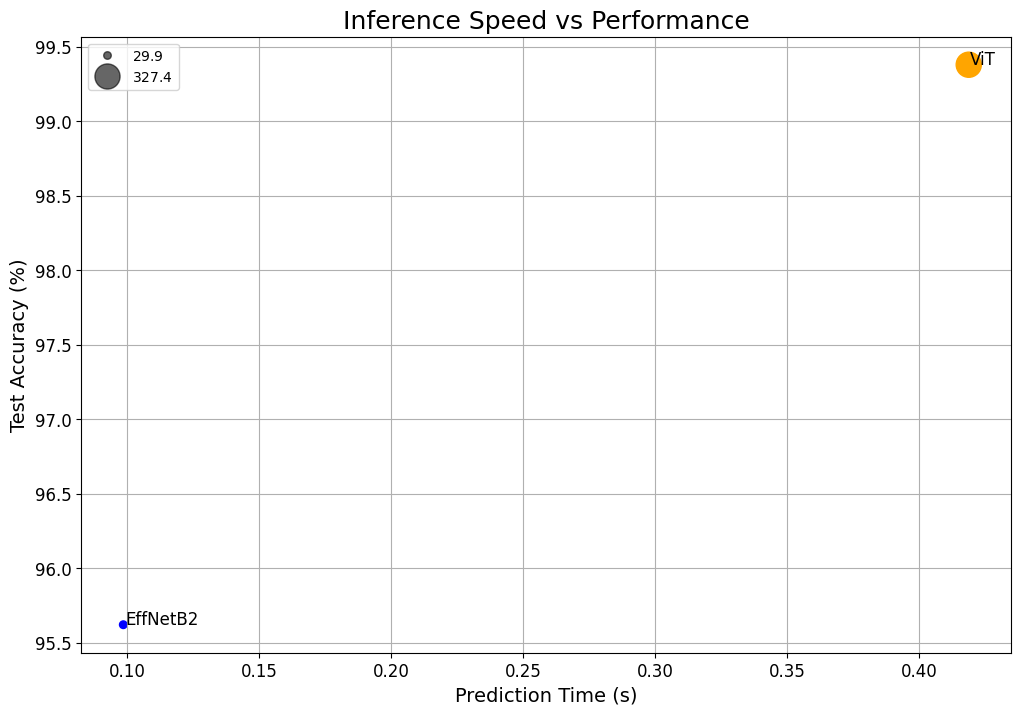

In [50]:
fig, ax = plt.subplots(figsize=(12,8))
scatter = ax.scatter(data=df, x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"],
                     s="model_size (MB)")

ax.set_title("Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction Time (s)", fontsize=14)
ax.set_ylabel("Test Accuracy (%)", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.grid(True)

for index, row in df.iterrows():
  ax.annotate(text=row["model"],
              xy=(row["time_per_pred_cpu"] + 0.0006, row["test_acc"] + 0.003),
              size=12)

  handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
  model_size_legend = ax.legend(handles, labels, loc="upper left")

  ## Save the figure
 # plt.savefig("./images/inference_speed_vs_performance.png")

## We will deploy Effnet Using Gradio

In [51]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

Gradio version: 5.31.0


In [52]:
effnetb2 = effnetb2.to("cpu")

next(iter(effnetb2.parameters())).device

device(type='cpu')

In [55]:
# Let's create a function that receives an image, and makes a prediction of one of our labels based on that image. It also returns the prediction time

from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
  # Timer logic
  start_time = timer()
  img = effnetb2_transforms(img).unsqueeze(0) # adds batch dimension

  effnetb2.eval()
  with torch.inference_mode():
    pred_logits = effnetb2(img)
    pred_probs = torch.softmax(pred_logits, dim=1)

  pred_labels_and_probs = {class_names[i] : float(pred_probs[0][i]) for i in range(len(class_names))}

  pred_time = round(timer() - start_time, 5)

  return pred_labels_and_probs, pred_time

  # Transform input image
  image_transform = effnetb2.transform

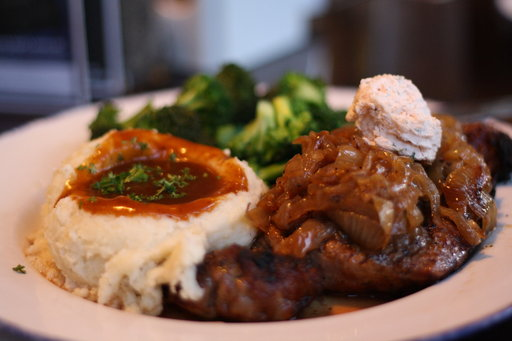

In [61]:
import random
from PIL import Image

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[0]

# Select random path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open image
img = Image.open(random_image_path)
img


In [63]:
print(f" [INFO] Predicting on image at path {random_image_path}")
pred_dict, pred_time = predict(img=img)
pred_dict, pred_time

 [INFO] Predicting on image at path data/pizza_steak_sushi_20_percent/test/steak/48208.jpg


({'pizza': 0.10030140727758408,
  'steak': 0.5672782063484192,
  'sushi': 0.33242037892341614},
 0.74102)

## Creating Example Images

In [65]:
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/steak/3173402.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/2352914.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/3100563.jpg']]

In [67]:
import gradio as gr

# Create Title, description and article

title = "Sushi, Steak and Pizza Classification with PyTorch and EfficientNetB2"
description  = "An EfficientNetB2 feature extractor."

## Create demo

demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description)

demo.launch(debug=False, share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1d5655fbb2ef2a5de1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
